# ニューラルネットワークによるMNISTデータセットの認識実験

---
## 目的
多層パーセプトロン (Multi Layer Perceptoron; MLP) を用いてMNISTデータセットに対する文字認識を行う．
また，使用する活性化関数の違いによる認識性能の変化を確認する．

## 対応するチャプター
* 6.2.2: マルチヌーイ分布出力のためのソフトマックスユニット
* 6.3: ReLUとその一般化
* 8.1.3: バッチアルゴリズムとミニバッチアルゴリズム
* 8.3.1: 確率的勾配降下法

## モジュールのインポート
プログラムの実行に必要なモジュールをインポートします．
実験には深層学習ライブラリの一つであるchainerを使用します．
使用するクラス，関数は以下の通りです．

* `chainer`は深層学習を使用するためのPythonライブラリ
* `get_mnist`はMNISTデータセットを使用するための関数

In [20]:
from time import time
import numpy as np
import matplotlib.pyplot as plt

import chainer
from chainer.datasets import get_mnist
from chainer import cuda
from chainer import Variable
import chainer.functions as F
import chainer.links as L

## GPUの確認
GPUを使用した計算が可能かどうかを確認します．

`GPU avilability: True`と表示されれば，GPUを使用した計算をChainerで行うことが可能です．
Falseとなっている場合は，上記の「Google Colaboratoryの設定確認・変更」に記載している手順にしたがって，設定を変更した後に，モジュールのインポートから始めてください．

In [14]:
print('GPU availability:', chainer.cuda.available)
print('cuDNN availablility:', chainer.cuda.cudnn_enabled)

GPU availability: True
cuDNN availablility: True


## データセットの読み込み
学習データ（MNISTデータセット）を読み込みます．

MNISTデータセットの読み込みには`get_mnist`関数を使用します．
読み込んだ学習データのサイズを確認します．
学習データ数は6万枚．1つのデータのサイズは786次元となっています．

In [15]:
train_dataset, test_dataset = chainer.datasets.get_mnist()
train_x, train_y = train_dataset._datasets
test_x, test_y = test_dataset._datasets

print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(60000, 784) (60000,)
(10000, 784) (10000,)


### MNISTデータセットの表示
MNISTデータセットに含まれる画像を表示してみます．
ここでは，matplotlibを用いて複数の画像を表示させるプログラムを利用します．

<Figure size 432x288 with 0 Axes>

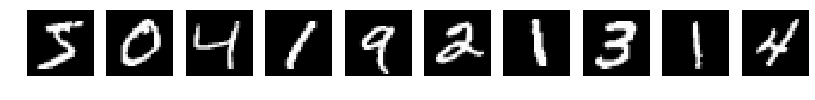

In [16]:
plt.clf()
fig = plt.figure(figsize=(14, 1.4))
for c in range(10):
    ax = fig.add_subplot(1, 10, c + 1)
    ax.imshow(train_x[c].reshape(28, 28), cmap=plt.get_cmap('gray'))
    ax.set_axis_off()
plt.show()

## ネットワークモデルの定義
ニューラルネットワークを定義します．
ここでは，入力層，中間層，出力層から構成される3層のニューラルネットワークとします．

入力層のユニット数は入力データのサイズによります．
ここでは`None`とし，データにより変更できるようにしておきます．

中間層と出力層のユニット数は引数として与え，`n_hidden`，`n_out`とします．
Chainerでは，`__init__`関数にこれらの引数を与えて各層を定義します．
各層は`Linear`関数としています．これは全結合層を意味しています．

そして，`__call__`関数で定義した層を接続して処理するように記述します．
`__call__`関数の引数`x`は入力データです．
それを`__init__`関数で定義した`l1`という中間層に与え，その出力を活性化関数である`sigmoid`関数に与えます．
その出力を`h`としています．
`h`はさらに`l2`層，`l3`層へ入力することで，最終的な結果を出力します．

In [27]:
class MLP(chainer.Chain):
    def __init__(self, n_hidden, n_out):
        super(MLP, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, n_hidden)
            self.l2 = L.Linear(n_hidden, n_hidden)
            self.l3 = L.Linear(n_hidden, n_out)

    def __call__(self, x):
        # 課題2: 活性化関数の変更
        # h = F.relu(self.l1(x))        # ReLUを使用する場合
        # h = F.leaky_relu(self.l1(x))  # leaky ReLUを使用する場合
        
        h = F.sigmoid(self.l1(x))
        h = F.sigmoid(self.l2(h))
        h = self.l3(h)
        return h

## ネットワークの作成と学習の準備
上のプログラムで定義したネットワークを作成します．


まず，中間層と出力層のユニット数を定義します．
ここでは，中間層のユニット数`n_units`16，出力層のユニット数`out_units`を10とします．

各層のユニット数を`MLP`クラスの引数として与え，ネットワークを作成します．

学習を行う際の最適化方法としてモーメンタムSGD(モーメンタム付き確率的勾配降下法）を利用します．
また，学習率を0.01，モーメンタムを0.9として引数に与えます．
そして，最適化方法のsetup関数にネットワークモデルを与えます．

In [29]:
# ユニット数の定義
hidden_units = 64
out_units = 10

# ネットワークの作成
model = MLP(n_hidden=hidden_units, n_out=out_units)

# 最適化手法の設定
optimizer = chainer.optimizers.MomentumSGD(lr=0.01, momentum=0.9)
optimizer.setup(model)

## 学習
読み込んだMNISTデータセットと作成したネットワークを用いて，学習を行います．

1回の誤差を算出するデータ数（ミニバッチサイズ）を100，学習エポック数を10とします．

学習を開始します．
MNISTの学習データサイズを取得し，1エポック内における更新回数を求めます．
学習データは毎エポックでランダムに利用するため，numpyの`permutation`という関数を利用します．
各更新において，学習用データと教師データをそれぞれ`x`と`t`とします．
学習モデルに`x`を与えて各クラスの確率`y`を取得します．
各クラスの確率`y`と教師ラベル`t`との誤差を`softmax_coross_entropy`誤差関数で算出します．
また，認識精度も算出します．
そして，誤差を`backward`関数で逆伝播し，ネットワークの更新を行います．

In [30]:
# ミニバッチサイズ・エポック数．学習データ数の設定
batch_size = 100
epoch_num = 10
train_data_num = train_x.shape[0]

# 学習の実行
for epoch in range(epoch_num):
    sum_loss = 0
    sum_accuracy = 0
    perm = np.random.permutation(train_data_num)
    for i in range(0, train_data_num, batch_size):
        x = Variable(train_x[perm[i:i+batch_size]])
        t = Variable(train_y[perm[i:i+batch_size]])

        model.zerograds()
        y = model(x)
        loss = F.softmax_cross_entropy(y, t)
    
        acc = F.accuracy(y, t)
    
        loss.backward()
        optimizer.update()
    
        sum_loss += loss.data*batch_size
        sum_accuracy += acc.data*batch_size
    
    print("epoch: {}, mean loss: {}, mean accuracy: {}".format(epoch+1,
                                                               sum_loss/train_data_num,
                                                               sum_accuracy/train_data_num))

epoch: 1, mean loss: 1.8885282135009767, mean accuracy: 0.43724999894698463
epoch: 2, mean loss: 0.7899873351554075, mean accuracy: 0.7945833313465118
epoch: 3, mean loss: 0.4927979425092538, mean accuracy: 0.8692333319783211
epoch: 4, mean loss: 0.3940342067430417, mean accuracy: 0.8931500013669332
epoch: 5, mean loss: 0.3455557468285163, mean accuracy: 0.9028666686018308
epoch: 6, mean loss: 0.31530929408967495, mean accuracy: 0.9104000016053517
epoch: 7, mean loss: 0.2934815970187386, mean accuracy: 0.9166500020027161
epoch: 8, mean loss: 0.2752473972986142, mean accuracy: 0.9209833358724911
epoch: 9, mean loss: 0.25971410458286603, mean accuracy: 0.9258833354711533
epoch: 10, mean loss: 0.24585191143055757, mean accuracy: 0.9287666689356168


## テスト
学習したネットワークを用いて，テストデータに対する認識率の確認を行います．

In [25]:
count = 0
test_data_num = test_x.shape[0]

with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
    for i in range(test_data_num):
        x = Variable(np.array([test_x[i]], dtype=np.float32))
        t = test_y[i]
        y = model(x)
        y =np.argmax(y.data[0])
        if t == y:
            count += 1
    
    print("test accuracy: {}".format(count/test_data_num))

test accuracy: 0.9225


## 課題
1. ネットワークの中間層のユニット数を変更して認識性能の変化を確認しましょう
2. 活性化関数を変更して認識性能の変化を確認しましょう